In [19]:
import numpy as np
import json
import csv
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import re
from IPython.display import display
import matplotlib.pyplot as plt
from tqdm import tqdm
from efficient_apriori import apriori

In [2]:
with open('data/kaggle/train.json') as f:
    data = json.load(f)
with open('data/nationalities.csv', 'r') as f:
    reader = csv.reader(f)
    nationalities = [item.lower() for sublist in list(reader)[1:] for item in sublist]
with open('data/to_remove.csv', 'r') as f:
    reader = csv.reader(f)
    to_remove = [item.lower() for sublist in list(reader) for item in sublist]

In [3]:
baseURL = "https://en.wikipedia.org/wiki/"

ingr_size = list(['small', 'medium', 'large', 'big', 'flat'])

ingr_parts = list(['breast','breasts', 'tender', 'tenders', 'ribs', 'shoulder', 'fillet',
                   'steak', 'tigh', 'liver', 'livers',
                   'clove', 'cloves', 'leaf', 'leaves', 'flakes', 'threads', 'paste',
                   'piece', 'pieces', 'slice', 'slices', 'crumbles', 'powder', 'blend', 'mix'])

ingr_state = list(['grilled', 'roasted', 'toasted', 'fried', 'baked', 'cooked',
              'chopped', 'cut', 'sliced', 'shredded',
              'frozen', 'refrigerated', 'fresh', 'freshly', 'organic', 'natural', 'active',
              'boneless', 'skinless', 'condensed', 'ground', 'warm', 'cold'])

ingr_color = list(['purple', 'yellow', 'blue', 'red', 'white', 'black', 'green', 'brown'])

#to_remove_step1 = ingr_size+ingr_parts+ingr_state
to_remove_step2 = ingr_color



to_remove_step1  = list(['crumbles', 'ground', 'grilled', 'roasted', 'toasted', 'fried', 'baked', 'chopped',
                         'frozen', 'refrigerated', 'boneless', 'natural', 'organic', 'fresh', 'freshly',
                         'medium', 'large','big', 'small', 'breasts', 'tender', 'ribs', 'shoulder', 'paste', 'cloves', 'slivered',
                         'condensed', 'cut', 'piece', 'pieces', 'sliced', 'cooked', 'grated'])
to_remove_step2  = list(['purple', 'yellow', 'blue', 'red', 'white', 'black', 'green', 'dried'])

In [4]:
"""def try_find_ingredient2(ingr_list):
    ingr = '+'.join(ingr_list)
    str1 = "Went to foodDB for: "+ingr+" -> "
    try:
        url = urlopen(baseURL2+ingr)
    except:
        return ""
    res = BeautifulSoup(url.read(),"html5lib");
    title = res.find(class_= "hit-name").text.lower()
    title = re.sub(r" \(.*\)","", title)
    join = [value for value in title.split() if value in ingr_list]
    if len(join) > 0:
        title = ' '.join(join)
    print(str1+title)
    return title"""

def try_find_ingredient(ingr_list):
    ingr = '_'.join(ingr_list)
    try:
        url = urlopen(baseURL+ingr)
    except:
        return ""
    res = BeautifulSoup(url.read(),"html5lib");
    title = res.find(id="firstHeading").text.lower()
    title = re.sub(r" \(.*\)","", title) #remove (desambiguation)
    return title

In [5]:
"""def clean_ingredient(ingr):
    ingr = ingr.split(',')[0].split('(')[0].replace('%', "").lower()
    ingredient_list = [ing for ing in ingr.split() if (ing not in nationalities and not ing.isdigit()) ]
    ingredient = try_find_ingredient(ingredient_list)
    if ingredient == "":
        ingredient_list = [word for word in ingredient_list if (word not in to_remove)]
        ingredient = try_find_ingredient(ingredient_list)
        if ingredient == "":
            ingredient = ' '.join(ingredient_list)
        else:
            print('FOUND AT 2ND SEARCH')
    return ingredient"""

def clean_ingredient(ingr):
    ingr = re.sub(r'\([^)]*\)','', ingr)
    ingr = ingr.split(',')[0].replace('%', "").lower()
    ingredient_list = [ing for ing in ingr.split() if (ing not in nationalities and not ing.isdigit()) ]
    ingredient = ""#try_find_ingredient(ingredient_list)
    if ingredient == "":
        ingredient_list = [word for word in ingredient_list if (word not in to_remove)]
        ingredient = ' '.join(ingredient_list)
    return ingredient

In [6]:
def get_ingredients_from_recipe(recipe):
    ingredients = set()
    for ingr in recipe['ingredients']:
        cleaned_ingr = clean_ingredient(ingr)
        if cleaned_ingr == "" and 'leaves' in ingr:
            cleaned_ingr = 'lettuce'
        if cleaned_ingr == "" and ingr == 'boneless, skinless chicken breast':
            cleaned_ingr = 'chicken breasts'
        if cleaned_ingr:
            ingredients.add(cleaned_ingr)
            
    return list(ingredients)

In [7]:
def print_ingredients_from_recipe(recipe):
    table = list()
    for ingr in recipe['ingredients']:
        cleaned_ingr = clean_ingredient(ingr)
        table.append((ingr, cleaned_ingr))
    df = pd.DataFrame.from_records(table, columns=['from', 'to'])
    display(df)

In [8]:
len(data)

39774

In [17]:
%%time
table = list()
for recipe in tqdm(data):
    ingredients = get_ingredients_from_recipe(recipe)
    table.append(tuple(ingredients))

100%|██████████| 39774/39774 [00:05<00:00, 7271.38it/s]


Wall time: 5.5 s


In [10]:
df_unique = df['to'].unique()
len(df_unique)

5552

[]

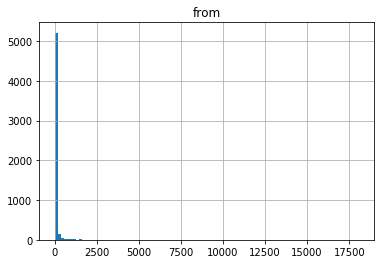

In [11]:
df_count = df.groupby('to').agg('count')
df_count.hist(bins=100)
plt.plot()

In [12]:
(df_count[df_count['from']>=4].sum()) / df_count.sum()

from    0.99067
dtype: float64

C:\Users\Lucas\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2084: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)


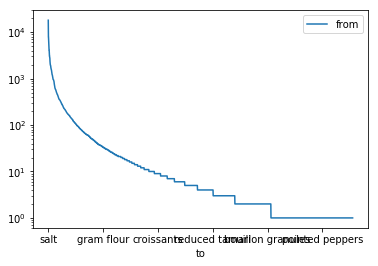

In [13]:
df_count.sort_values(by='from',ascending=False).plot(logy = True)

## Apriori implementation

In [28]:
%%time
itemsets, rules = apriori(table, min_support=0.005,  min_confidence=0.7)
print(rules)

[{baking powder} -> {salt}, {baking soda} -> {salt}, {tomatillos} -> {cilantro}, {coriander powder} -> {salt}, {cornmeal} -> {salt}, {garam masala} -> {salt}, {onion powder} -> {garlic powder}, {mirin} -> {soy sauce}, {mustard seeds} -> {salt}, {oyster sauce} -> {soy sauce}, {pepper} -> {salt}, {rice wine} -> {soy sauce}, {sake} -> {soy sauce}, {turmeric} -> {salt}, {yeast} -> {salt}, {yellow corn meal} -> {salt}, {sesame oil} -> {soy sauce}, {shaoxing wine} -> {soy sauce}, {yeast} -> {water}, {baking powder, baking soda} -> {all-purpose flour}, {baking powder, buttermilk} -> {all-purpose flour}, {all-purpose flour, baking powder} -> {salt}, {baking powder, unsalted butter} -> {all-purpose flour}, {baking powder, vanilla extract} -> {all-purpose flour}, {baking soda, buttermilk} -> {all-purpose flour}, {all-purpose flour, baking soda} -> {salt}, {baking soda, unsalted butter} -> {all-purpose flour}, {all-purpose flour, black pepper} -> {salt}, {all-purpose flour, brown sugar} -> {salt}


Wall time: 7min 31s


efficient_apriori.rules.Rule